## Portland State University
## SYSC 506, Spring Term 2021
## Scott Marler

### Project: Re-create Robert Axelrod's Iterated Prisoner's Dilemma tournament and attempt to defeat the Tit for Tat strategy 

In [1]:
from collections import defaultdict
from collections import Counter
import pandas as pd
import numpy as np
import random
from itertools import combinations
import operator
from sklearn.naive_bayes import BernoulliNB

import matplotlib.pyplot as plt

pd.set_option("max_rows", None)

## Axelrod's Tournament

### Gameplay
- Round Robin style, so everyone plays everyone else, including random and its own twin
- 200 moves per round
- Entire tournament is run 5 times, and overall outcome is based on the average score
- Players have access to the history of the game so far and may use that history to make a decision

### Scoring

| Player 1's Move | Player 2's Move | Player 1's Score | Player 2's Score |
| --- | --- | --- | --- |
| Cooperate | Cooperate | 3 | 3 |
| Cooperate | Defect | 0 | 5 |
| Defect | Cooperate | 5 | 0 |
| Defect | Defect | 1 | 1 |



In [2]:
score_dict = {
    ('c', 'c'): (3, 3),
    ('c', 'd'): (0, 5),
    ('d', 'c'): (5, 0),
    ('d', 'd'): (1, 1)
}

### Strategy Definition Part 1

The following cell contains strategies that have simple rules, such as
- pre-determined (always cooperate or always defect)
- probabilistic (cooperate ___ % of the time)

Note: `cooperate_half`, which is effectively a coin flip, is the model we consider "random" per Axelrod's description.

These strategies make no use of history.

In [3]:
# Always Cooperate
def cooperate(**kwargs):
    return 'c'

# Always Defect
def defect(**kwargs):
    return 'd'

# Cooperate 50% of the time
def cooperate_half(**kwargs):
    return 'c' if random.randrange(1, 100) <= 50 else 'd'

# Cooperate 80% of the time
def cooperate_80(**kwargs):
    return 'c' if random.randrange(1, 100) <= 80 else 'd'

# Cooperate 20% of the time
def cooperate_20(**kwargs):
    return 'c' if random.randrange(1, 100) <= 20 else 'd'

### Strategy Defnition Part 2

The following cell contains strategies that have simple rules that do make use of history. Most notable is Tit for Tat, which won Axelrod's tournaments.

Included are several variations on the theme, both of a more devious or more forgiving nature. An example of a more devious variant is `tftd`, which has a 10% chance to defect when tit for tat would have otherwise cooperated. A more forgiving example is `tftf`, which has a 25% to "forgive" a defection and cooperate on the next move anyway.

In [4]:
# Tit for Tat Default Cooperate
def tft(default='c', **kwargs):
    '''
    Return opponent's most recent move
    '''
    memory = kwargs['memory']
    return memory['o'][-1] if len(memory['o']) > 0 else default

# Tit for Tat with 25% chance to forgive defection
def tftf(default='c', **kwargs):
    '''
    Return opponent's most recent move, 
    but with a 25% chance to forgive defection
    '''
    memory = kwargs['memory']
    if len(memory['o']) == 0:
        return default
    
    o_last_move = memory['o'][-1]
    if o_last_move == 'c' or random.randrange(1, 100) <= 25:
        return 'c'
    else:
        return 'd'

# Tit for Tat with 10% chance to defect
def tftd(default='c', **kwargs):
    '''
    Return opponent's most recent move,
    but with a 10% chance to defect instead of cooperate
    '''
    memory = kwargs['memory']
    if len(memory['o']) == 0:
        return default
    
    o_last_move = memory['o'][-1]
    if o_last_move == 'd' or random.randrange(1, 100) <= 10:
        return 'd'
    else:
        return 'c'

# Tit for 2 Tats
def tftt(default='c', **kwargs):
    '''
    Defect only if player's 2 most recent moves were defect
    Otherwise cooperate
    '''
    memory = kwargs['memory']
    if len(memory['o']) < 2:
        return default
    
    if memory['o'][-2] == 'd' and memory['o'][-1] == 'd':
        return 'd'
    else:
        return 'c'


# Tit for 2 Tats with 25% chance to forgive defection
def tftt_gentle(default='c', **kwargs):
    '''
    75% chance to defect only if player's 2 most recent moves were defect
    Otherwise cooperate
    '''
    memory = kwargs['memory']
    if len(memory['o']) < 2:
        return default
    
    if memory['o'][-2] == 'd' and memory['o'][-1] == 'd' and random.randrange(1, 100) <= 75:
        return 'd'
    else:
        return 'c'

# Tit for Majority Tats in last 5 moves
def tfmt(default='c', **kwargs):
    '''
    Default cooperate for 5 moves, 
    then match the majority of opponent's last 5
    '''
    memory = kwargs['memory']
    if len(memory['o']) < 5:
        return default
    last_5 = Counter(memory['o'][-5:])
    return sorted(last_5, key=last_5.__getitem__, reverse=True)[0]

# Tit for Majority Tats in last 5 moves with 25% chance to forgive defection
def tfmt_gentle(default='c', **kwargs):
    '''
    Default cooperate for 5 moves, 
    then match the majority of opponent's last 5, 
    but if defect, 25% chance to cooperate anyway
    '''
    memory = kwargs['memory']
    if len(memory['o']) < 5:
        return default
    
    last_5 = Counter(memory['o'][-5:])
    maj = sorted(last_5, key=last_5.__getitem__, reverse=True)[0]
    if maj == 'c' or random.randrange(1, 100) <= 25:
        return 'c'
    else:
        return 'd'


### Strategy Definition Part 3

The following cell contains strategies that build prediction models.

The `nb` Naive Bayes model re-trains after every move. The model is based on the independent variable of the player's own move prior to the opponent's move. The opponent's move is the dependent variable. What we're trying to do is predict what the opponent will play based on our own previous move. In the case of a tit for tat opponent, the model learns very quickly that our previous move determines `tft`'s following move.

Because it is advantageous for the overall tournament results if both players cooperate, the `nb` model will cooperate if it predicts opponent cooperation. If it predicts defection, it will also defect.

`nb_steering`, however, goes one step further. The model is built the same way as for `nb`, but instead of predicting the opponent's next move, we evaulate our own ability to control our opponent's next move. If `nb_steering` believes a cooperation will yield the opponent's cooperation on the _following_ move, we cooperate even if it means that we believe our opponent will defect on the current play. This is because the prospect of steering toward mutual cooperation is more important for the tournament outcome than any one round or the outcome of any one game.

In [5]:
# Naive Bayes 
def nb(default='c', **kwargs):
    '''
    Train a Naive Bayes model where:
        - the IVs are my moves up until my last move
        - the DVs are opponent moves _following_ my moves
    The goal of this strategy is to play whatever we think our opponent will play next
    '''
    memory = kwargs['memory']
    rounds_played = len(memory['o'])
    # Scripted start to establish baseline for model
    if rounds_played <= 2:
        return 'c'
    elif rounds_played == 3:
        return 'd'
    elif rounds_played <= 5:
        return 'c'
    
    # Handle the case where they only play the same thing
    # If they always cooperate, so will we
    # If they always defect, so will we
    moves_so_far = Counter(memory['o'])
    if len(moves_so_far) == 1:
        return sorted(moves_so_far, key=moves_so_far.__getitem__, reverse=True)[0]
    
    classifier = BernoulliNB()
    X_train = [[1] if move == 'c' else [0] for move in memory['s'][:-1]]
    y_train = [1 if move == 'c' else 0 for move in memory['o'][1:]]
    classifier.fit(X_train, y_train)
    my_last = memory['s'][-1]
    y_pred = classifier.predict([[1 if my_last == 'c' else 0]])
    return 'c' if y_pred == 1 else 'd'

# Naive Bayes with Steering Toward Cooperation
def nb_steering(default='c', **kwargs):
    '''
    Train a Naive Bayes model where:
        - the IVs are my moves up until before my last move
        - the DVs are opponent moves _following_ my moves
    - Cooperate for the first 2 moves
    - Defect next 1
    - Cooperate next 2
    - From then on, predict the probability that our cooperation
      will lead to opponent's cooperation
      
      - if we are 90% confident, then cooperate
      - if we are 75% confident, then match predicted next move
      - else defect
    '''
    memory = kwargs['memory']
    rounds_played = len(memory['o'])
    # Scripted start to establish baseline for model
    if rounds_played <= 2:
        return 'c'
    elif rounds_played == 3:
        return 'd'
    elif rounds_played <= 5:
        return 'c'
    else:

        # Handle the case where they only play the same thing
        # If they always cooperate, so will we
        # If they always defect, so will we
        moves_so_far = Counter(memory['o'])
        if len(moves_so_far) == 1:
            return sorted(moves_so_far, key=moves_so_far.__getitem__, reverse=True)[0]
        
        classifier = BernoulliNB()
        X_train = [[1] if move == 'c' else [0] for move in memory['s'][:-1]]
        y_train = [1 if move == 'c' else 0 for move in memory['o'][1:]]
        classifier.fit(X_train, y_train)
        coop_influence = classifier.predict_proba([[1]])[0][1]

        if coop_influence >= .9:
            return 'c'
        elif coop_influence >= .75:
            my_last = memory['s'][-1]
            y_pred = classifier.predict([[1 if my_last == 'c' else 0]])
            return 'c' if y_pred == 1 else 'd'
        else:
            return 'd'
        
# Naive Bayes with Steering Toward Cooperation
# This version is tuned to require more confidence in the opponent's next move
# Hence "cautious"
def nb_steering_cautious(default='c', **kwargs):
    '''
    Train a Naive Bayes model where:
        - the IVs are my moves up until before my last move
        - the DVs are opponent moves _following_ my moves
    - Cooperate for the first 2 moves
    - Defect next 1
    - Cooperate next 2
    - From then on, predict the probability that our cooperation
      will lead to opponent's cooperation
      
      - if we are >=95% confident, then cooperate
      - if we are >=80% confident, then match predicted next move
      - else defect
    '''
    memory = kwargs['memory']
    rounds_played = len(memory['o'])
    # Scripted start to establish baseline for model
    if rounds_played <= 2:
        return 'c'
    elif rounds_played == 3:
        return 'd'
    elif rounds_played <= 5:
        return 'c'
    else:

        # Handle the case where they only play the same thing
        # If they always cooperate, so will we
        # If they always defect, so will we
        moves_so_far = Counter(memory['o'])
        if len(moves_so_far) == 1:
            return sorted(moves_so_far, key=moves_so_far.__getitem__, reverse=True)[0]
        
        classifier = BernoulliNB()
        X_train = [[1] if move == 'c' else [0] for move in memory['s'][:-1]]
        y_train = [1 if move == 'c' else 0 for move in memory['o'][1:]]
        classifier.fit(X_train, y_train)
        coop_influence = classifier.predict_proba([[1]])[0][1]

        if coop_influence >= .95:
            return 'c'
        elif coop_influence >= .8:
            my_last = memory['s'][-1]
            y_pred = classifier.predict([[1 if my_last == 'c' else 0]])
            return 'c' if y_pred == 1 else 'd'
        else:
            return 'd'

### We now gather up the strategies defined above and instantiate players with those strategies

In [6]:
# Gather up the strategies defined above
strategies = {
    'cooperate': cooperate,
    'defect': defect,
    'cooperate_half': cooperate_half,
    'cooperate_80': cooperate_80,
    'cooperate_20': cooperate_20,
    'tit_for_tat': tft,
    'tit_fot_tat_forgiving': tftf,
    'tit_fot_tat_defecting': tftd,
    'tit_fot_two_tats': tftt,
    'tit_fot_two_tats_gentle': tftt_gentle,
    'tit_fot_majority_tats': tfmt,
    'tit_for_majority_tats_gentle': tfmt_gentle,
    'naive_bayes': nb,
    'naive_bayes_steering': nb_steering,
    'naive_bayes_steering_cautious': nb_steering_cautious
}

# Define player class - every contestant will be an instance of this class
class Player():
    def __init__(self, player_id, strategy):
        self.player_id = player_id
        self.strategy_name = strategy
        self.strategy_function = strategies[strategy]
        self.memory = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
        self.games_played = 0
        
    def __str__(self):
        return f'player_id={self.player_id}, strategy={self.strategy_name}'
        
    def __lt__(self, other):
        # makes class instances sortable by player_id
        return self.player_id < other.player_id
    
    def play(self, tournament_id, game_id, opponent_id):
        return self.strategy_function(memory=self.memory[tournament_id][game_id][opponent_id])
    
    def process_result(self, my_move, opponent_id, opponent_move, tournament_id, game_id):
        self.memory[tournament_id][game_id][opponent_id]['o'].append(opponent_move)
        self.memory[tournament_id][game_id][opponent_id]['s'].append(my_move)
        self.games_played += 1
        
# Instantiate each player and provide the mapped strategy to the Player class
player_id = 1
players = {}
strategy_lookup = {}
players_mirror = {}
for s in strategies:
    p = Player(player_id, s)
    players[p.player_id] = p
    pm = Player(player_id, s)
    players_mirror[p.player_id] = pm
    
    strategy_lookup[player_id] = s
    
    player_id += 1

### The scoreboard object will store the outcome of every game for every tournament iteration

In [7]:
class Scoreboard():
    def __init__(self):
        self.print_formatter = '| {0:10} | {1:10} | {2:30} | {3:5} |'
        self.print_header = self.print_formatter.format('tourney_id', 'player_id', 'strategy', 'score')
        self.print_divider = '*' * 69
        self.game_scores = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        self.outcome_matrix = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
        # game_scores[tournament_id][game_id][player_id] = [1, 0, 5, 3, 0, 0, 1, ...]
        
        self.game_outcomes = defaultdict(lambda: defaultdict(int))
        # game_outcomes[player_id]['win'] = 5
        # game_outcomes[player_id]['loss'] = 7
        # game_outcomes[player_id]['tie'] = 1
        
        self.tourney_scores = defaultdict(lambda: defaultdict(int))
        # tourney_scores[tournament_id][player_id] = 529
        
    def print_scores(self):
        print(self.print_header)
        print(self.print_divider)
        for t in self.tourney_scores:
            for p in self.tourney_scores[t]:
                print(self.print_formatter.format(t, p, strategy_lookup[p], self.tourney_scores[t][p]))

tourney_scoreboard = Scoreboard()

Functions below control the flow for an overall tournament and for each individual head-to-head matchup

In [8]:
def play_game(p1, p2, moves_per_game, tournament_id, game_id, verbose=False):
    '''
    Simulates one game between p1 and p2
    For each move in moves_per_game,
        Calls on their class functions to produce the next move
        Calls on their class functions again to record outcomes
    '''
    if verbose:
        print(f'simulating {moves_per_game} moves between {p1.strategy_name} and {p2.strategy_name}')
    
    p1_cumulative_score = 0
    p2_cumulative_score = 0
    
    for _ in range(moves_per_game):
        p1_move = p1.play(tournament_id, game_id, p2.player_id)
        p2_move = p2.play(tournament_id, game_id, p1.player_id)
        
        p1.process_result(p1_move, p2.player_id, p2_move, tournament_id, game_id)
        p2.process_result(p2_move, p1.player_id, p1_move, tournament_id, game_id)
        
        p1_score, p2_score = score_dict[(p1_move, p2_move)]
        
        # record move scores
        tourney_scoreboard.game_scores[tournament_id][game_id][p1.player_id].append(p1_score)
        tourney_scoreboard.game_scores[tournament_id][game_id][p2.player_id].append(p2_score)
        
        p1_cumulative_score += p1_score
        p2_cumulative_score += p2_score
        
    # cumulative scores determine the ultimate tournament winner
    tourney_scoreboard.tourney_scores[tournament_id][p1.player_id] += p1_cumulative_score
    tourney_scoreboard.tourney_scores[tournament_id][p2.player_id] += p2_cumulative_score
    
    # game w/l/t stats are just interesting
    if p1_cumulative_score > p2_cumulative_score:
        tourney_scoreboard.game_outcomes[p1.player_id]['win'] += 1
        tourney_scoreboard.outcome_matrix[p1.player_id][p2.player_id]['win'] += 1
        tourney_scoreboard.game_outcomes[p2.player_id]['loss'] += 1
        tourney_scoreboard.outcome_matrix[p2.player_id][p1.player_id]['loss'] += 1
        
    elif p1_cumulative_score < p2_cumulative_score:
        tourney_scoreboard.game_outcomes[p1.player_id]['loss'] += 1
        tourney_scoreboard.outcome_matrix[p1.player_id][p2.player_id]['loss'] += 1
        tourney_scoreboard.game_outcomes[p2.player_id]['win'] += 1
        tourney_scoreboard.outcome_matrix[p2.player_id][p1.player_id]['win'] += 1
    else:
        tourney_scoreboard.game_outcomes[p1.player_id]['tie'] += 1
        tourney_scoreboard.outcome_matrix[p1.player_id][p2.player_id]['tie'] += 1
        if p1.player_id == p2.player_id:
            pass
        else:
            tourney_scoreboard.game_outcomes[p2.player_id]['tie'] += 1
            tourney_scoreboard.outcome_matrix[p2.player_id][p1.player_id]['tie'] += 1
        
def run_tournament(tournament_id, moves_per_game=200):
    '''
    Executes play_game for every combination of players in the tourney
    '''
    game_id = 0
    
    for p1, p2 in combinations(list(players.keys()), 2):
        play_game(players[p1], players[p2], moves_per_game, tournament_id, game_id)
        game_id += 1
    # Every player must also compete against their own strategy
    for p in players:
        play_game(players[p], players_mirror[p], moves_per_game, tournament_id, game_id)
        game_id += 1

Play x number of tournaments, where a tournament consists of every player matching up against every other player, including a mirrored instance of itself.

In [9]:
tourneys = 20

for t in range(tourneys):
    tournament_id = t+1
    run_tournament(tournament_id)

In [10]:
# Display each player's tourney score for each tournament run
tourney_scoreboard.print_scores()

| tourney_id | player_id  | strategy                       | score |
*********************************************************************
|          1 |          1 | cooperate                      |  8052 |
|          1 |          2 | defect                         |  6000 |
|          1 |          3 | cooperate_half                 |  7122 |
|          1 |          4 | cooperate_80                   |  8178 |
|          1 |          5 | cooperate_20                   |  6159 |
|          1 |          6 | tit_for_tat                    |  8425 |
|          1 |          7 | tit_fot_tat_forgiving          |  8461 |
|          1 |          8 | tit_fot_tat_defecting          |  8077 |
|          1 |          9 | tit_fot_two_tats               |  8502 |
|          1 |         10 | tit_fot_two_tats_gentle        |  8347 |
|          1 |         11 | tit_fot_majority_tats          |  8626 |
|          1 |         12 | tit_for_majority_tats_gentle   |  8439 |
|          1 |         13 | naive

In [11]:
# Construct a final output dataframe with each strategy, average tourney score, and win/loss/tie records overall
wl_df = pd.DataFrame({strategy_lookup[k]: v for k, v in tourney_scoreboard.game_outcomes.items()}).T.astype('Int64').fillna(0).reset_index()
wl_df.rename(columns={'index': 'strategy'}, inplace=True)

avg_scores_df = pd.DataFrame(tourney_scoreboard.tourney_scores).apply(lambda s: np.mean(s), axis=1).reset_index()
avg_scores_df.rename(columns={'index': 'player_id', 0: 'mean_score'}, inplace=True)
avg_scores_df['strategy'] = avg_scores_df.player_id.map(strategy_lookup)
avg_scores_df = avg_scores_df[['mean_score', 'strategy']].sort_values('mean_score', ascending=False)

final_results = pd.merge(avg_scores_df, wl_df, on='strategy')

final_results[['strategy', 'mean_score', 'win', 'loss', 'tie']]

,strategy,mean_score,win,loss,tie
0,naive_bayes_steering,8842.60,157,43,100
1,naive_bayes_steering_cautious,8835.55,163,35,102
2,naive_bayes,8614.00,140,69,91
3,tit_fot_majority_tats,8567.60,23,136,141
4,tit_fot_tat_forgiving,8467.00,0,121,179
5,tit_for_majority_tats_gentle,8448.30,0,160,140
6,tit_fot_two_tats,8444.95,0,160,140
7,tit_fot_two_tats_gentle,8376.60,0,160,140
8,tit_for_tat,8360.20,0,69,231
9,cooperate,8049.90,0,160,140


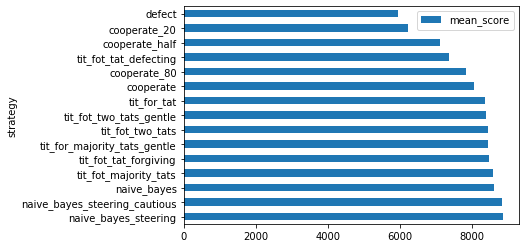

In [12]:
final_results.plot.barh('strategy', 'mean_score')
plt.show()

In [14]:
# Check game outcomes for naive_bayes_steering_cautious
nbs_outcomes = pd.DataFrame(tourney_scoreboard.outcome_matrix[15]).T.astype('Int64').fillna(0)
nbs_outcomes['opponent'] = nbs_outcomes.index.map(strategy_lookup)
nbs_outcomes[['opponent', 'win', 'loss', 'tie']]

,opponent,win,loss,tie
1,cooperate,20,0,0
2,defect,0,20,0
3,cooperate_half,20,0,0
4,cooperate_80,17,3,0
5,cooperate_20,20,0,0
6,tit_for_tat,0,0,20
7,tit_fot_tat_forgiving,6,0,14
8,tit_fot_tat_defecting,0,12,8
9,tit_fot_two_tats,20,0,0
10,tit_fot_two_tats_gentle,20,0,0


In [25]:
head_to_head_results = defaultdict(lambda: defaultdict(int))

for t_id in tourney_scoreboard.game_scores:
    tourney_scores = tourney_scoreboard.game_scores[t_id]
    for g_id in tourney_scores:
        game_scores = tourney_scores[g_id]
        players = list(game_scores.keys())
        if len(players) == 2:
            p1 = players[0]
            p2 = players[1]
            head_to_head_results[p1][p2] += sum(game_scores[p1])
            head_to_head_results[p2][p1] += sum(game_scores[p2])

In [48]:
score_matrix_df = pd.DataFrame(head_to_head_results).T.astype('Int64').astype('str').replace('nan', '')
score_matrix_df = score_matrix_df.reset_index().sort_values('index')
score_matrix_df.rename(columns={'index': 'id'}, inplace=True)
score_matrix_df['Strategy'] = score_matrix_df.id.map(strategy_lookup)
score_matrix_df[['id', 'Strategy'] + sorted(range(1, 16))]

,id,Strategy,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,cooperate,,0,6093,9663,2565,12000,12000,10857,12000,12000,12000,12000,11940,11940,11940
1,2,defect,20000,,12020,17100,7220,4080,8120,4080,4160,8020,4400,8412,4400,4400,4400
2,3,cooperate_half,15938,1995,,13210,4821,9102,10827,8209,12685,13368,9688,10935,8802,2365,2356
3,4,cooperate_80,13558,725,7235,,3437,11017,11753,10037,13066,13139,13017,13083,13488,6757,3928
4,5,cooperate_20,18290,3195,10766,15272,,6330,9419,5876,8892,11114,4308,7940,3581,3525,3570
5,6,tit_for_tat,12000,3980,9052,11002,6250,,12000,4980,12000,12000,12000,12000,11980,11980,11980
6,7,tit_fot_tat_forgiving,12000,2970,8257,10768,5419,12000,,10028,12000,12000,12000,12000,11962,11968,11968
7,8,tit_fot_tat_defecting,12762,3980,9324,11702,6251,5080,11603,,11831,12751,11414,12501,12377,9402,7359
8,9,tit_fot_two_tats,12000,3960,7585,9931,5462,12000,12000,10141,,12000,12000,12000,11940,11940,11940
9,10,tit_fot_two_tats_gentle,12000,2995,7223,9934,4774,12000,12000,10786,12000,,12000,12000,11940,11940,11940


## Outcome

The table above shows the combined score for all matchups with different opponents across all 20 tournaments. The rows indicate the player whose score we report, and the columns indicate the opponent.

Across multiple simulations of sets of 20 tournaments, naive_bayes_steering and naive_bayes_steering_cautious always come out on top against this field of opponents. What we can learn from this is that leading opponents toward cooperation, if possible, is the superior strategy for iterated prisoner's dillema. It is the "if possible" part of that statement that requires a more advanced algorithm. In this case, we used a Naive Bayes machine learning algorithm to decide whether or not we _think_ we can influence our opponent's next move. And it is with much delight that we observe the downfall of tit for tat.